In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB

In [93]:
#DEFINICIÓN DE FUNCIONES

def clean_dataset(df):
    
    variables_to_remove = ['OP_CARRIER_FL_NUM', 'DEP_TIME','ARR_TIME','TAXI_OUT', 'WHEELS_OFF','WHEELS_ON','TAXI_IN', 
                           'CANCELLED', 'CANCELLATION_CODE','DIVERTED','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY',
                           'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',
                           'Unnamed: 27','Unnamed: 0']

    df.drop(variables_to_remove, axis = 1, inplace = True)

    df=df.rename(columns={'FL_DATE':'DATE','OP_CARRIER':'AIRLINE','DEST':'DESTIN',
                    'CRS_DEP_TIME':'SCHED_DEPARTURE','DEP_DELAY':'DEPARTURE_DELAY',
                    'CRS_ARR_TIME':'SCHED_ARRIVAL','ARR_DELAY':'ARRIVAL_DELAY'})

    df.dropna(inplace = True)
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d', errors = 'coerce')
    return df


def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
def transform_hour(df):
    df['SCHED_DEPARTURE'] = df['SCHED_DEPARTURE'].apply(format_hour)
    df['SCHED_ARRIVAL'] = df['SCHED_ARRIVAL'].apply(format_hour)
    
    return df

def create_flight_time(df):    
    lista=[]
    for i,v in df[['DATE','SCHED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df['DATE'][i],df['SCHED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

    indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
    print ('Errors during data transformation :  ', len(indices))

    df['DATE_TIME']=lista
    return df


def airline_name(df):
    
    df["AIRLINE_NAME"]=df.apply(lambda x: airlines.loc
                           [airlines['CODE'] == x["AIRLINE"],"AIRLINE"].values[0],axis=1)
    return df

def geo (df):
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='ORIGIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'OR_LATITUDE','LONGITUDE':'OR_LONGITUDE'})
   
     df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='DESTIN', right_on='IATA_CODE')
     df=df.rename(columns={'LATITUDE':'DEST_LATITUDE','LONGITUDE':'DEST_LONGITUDE'})
    
    return df

def drop_code (df):
    variables_to_remove=['IATA_CODE_x','IATA_CODE_y']
    df=df.drop(variables_to_remove,axis = 1)
    return df

def outlier (df):
    #Outliers 
    # Drop'ARRIVAL_DELAY'>300 and 'ARRIVAL_DELAY'<-30
#     outlier1 = df['ARRIVAL_DELAY']>300
#     outrmv=df.index[outlier1].tolist()
#     df=df.drop(outrmv)
    outlier2 = df['ARRIVAL_DELAY']<-30
    outrmv=df.index[outlier2].tolist()
    df=df.drop(outrmv)
    return df

def classes (df):
    if df['ARRIVAL_DELAY']<15:
        delay=0
    elif df['ARRIVAL_DELAY']<50:     
        delay=1
#     elif df['ARRIVAL_DELAY']<120:
#         delay=2
    else:
        delay=2
    return delay

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [3]:
# CARGAMOS LOS DATASETS ADICIONALES
airports = pd.read_csv("dict/airports.csv")
airlines = pd.read_csv('dict/allairlines.csv', sep=';')
airlines_dict = airlines.set_index('CODE')['AIRLINE'].to_dict()

In [4]:
# SELECIONAMOS UNA MUESTRA DEL 20% DEL DATASET PRINCIPAL
df= pd.read_csv("data/2014.csv")
df_rnd=df.sample(frac = 0.2)
df_rnd.to_csv('sample/sample_2014.csv')

In [72]:
df.shape

(5819811, 28)

In [48]:
## LIMPIEZA Y PREPROCESADO
#Missing values
missing_df = df_rnd.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df_rnd.shape[0]-missing_df['missing values'])/df_rnd.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Unnamed: 27,1163962,0.000000
1,CANCELLATION_CODE,1138890,2.154022
2,SECURITY_DELAY,915449,21.350611
3,NAS_DELAY,915449,21.350611
4,WEATHER_DELAY,915449,21.350611
5,CARRIER_DELAY,915449,21.350611
6,LATE_AIRCRAFT_DELAY,915449,21.350611
7,AIR_TIME,28026,97.592189
8,ACTUAL_ELAPSED_TIME,28026,97.592189
9,ARR_DELAY,28026,97.592189


In [6]:
# Se diseña la carga de datos de modo que si hay varios archivos se puedan cargar iterativamente
csv_files = glob.glob('sample/*.csv')
#csv_files = glob.glob('data/*.csv')
# Mostrar el archivo csv_files, el cual es una lista de nombres
print(csv_files)

['sample\\sample_2014.csv']


In [58]:
list_data = []
p = Path('clean/')
# Escribimos un loop que irá a través de cada uno de los nombres de archivo 
# Aplicamos las funciones de limpieza y pre-procesado en el bucle

for filename in csv_files:
    data = pd.read_csv(filename)
    #Cleaning
    data = clean_dataset(data)
    data.dtypes
    #Datetime Transform
    data = transform_hour(data)
    data = create_flight_time (data)
    #Outliers
    data = outlier(data)
    #Airlines names
    data = airline_name(data)
    #Geo
    data = geo(data)
    data = drop_code(data)
    #Saving
    data.to_csv((Path(p, filename)), index=False)
    list_data.append(data)

Errors during data transformation :   0


In [59]:
list_data[0][['DATE_TIME','AIRLINE','AIRLINE_NAME','ORIGIN','OR_LATITUDE','OR_LONGITUDE','DESTIN','DEST_LATITUDE', 'DEST_LONGITUDE']].sort_values(by=['DATE_TIME'])

,DATE_TIME,AIRLINE,AIRLINE_NAME,ORIGIN,OR_LATITUDE,OR_LONGITUDE,DESTIN,DEST_LATITUDE,DEST_LONGITUDE
545818,2014-01-01 00:20:00,US,US Airways Inc.,SFO,37.61900,-122.37484,CLT,35.21401,-80.94313
2945,2014-01-01 00:23:00,UA,United Air Lines Inc.,SFO,37.61900,-122.37484,IAH,29.98047,-95.33972
6111,2014-01-01 00:25:00,UA,United Air Lines Inc.,LAX,33.94254,-118.40807,IAH,29.98047,-95.33972
81948,2014-01-01 01:20:00,AA,American Airlines Inc.,LAX,33.94254,-118.40807,DFW,32.89595,-97.03720
607011,2014-01-01 01:20:00,AS,Alaska Airlines Inc.,FAI,64.81368,-147.85967,SEA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...
264715,2014-12-31 23:43:00,UA,United Air Lines Inc.,SFO,37.61900,-122.37484,EWR,40.69250,-74.16866
268420,2014-12-31 23:51:00,UA,United Air Lines Inc.,LAX,33.94254,-118.40807,EWR,40.69250,-74.16866
400461,2014-12-31 23:55:00,DL,Delta Air Lines Inc.,SEA,47.44898,-122.30931,ATL,33.64044,-84.42694
225513,2014-12-31 23:59:00,B6,JetBlue Airways,LAS,36.08036,-115.15233,BOS,42.36435,-71.00518


In [9]:
### ANÁLISIS EXPLORATORIO

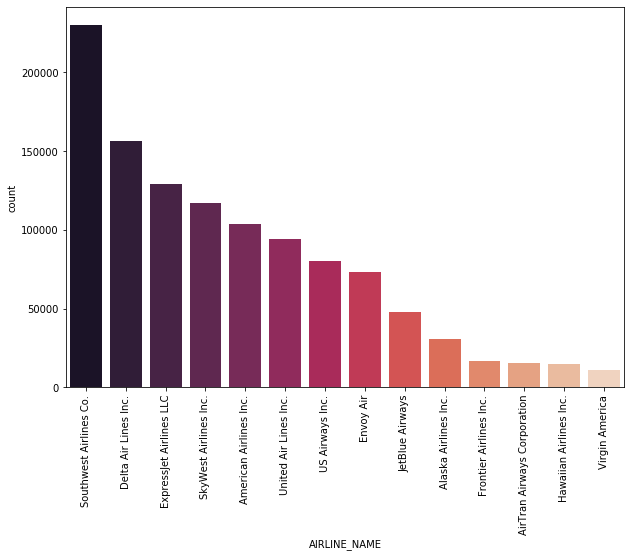

In [37]:
## Comparación entre Aerolíneas
# Total vuelos por aerolínea
plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE_NAME', data=list_data[0], palette="rocket", order = list_data[0]['AIRLINE_NAME'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

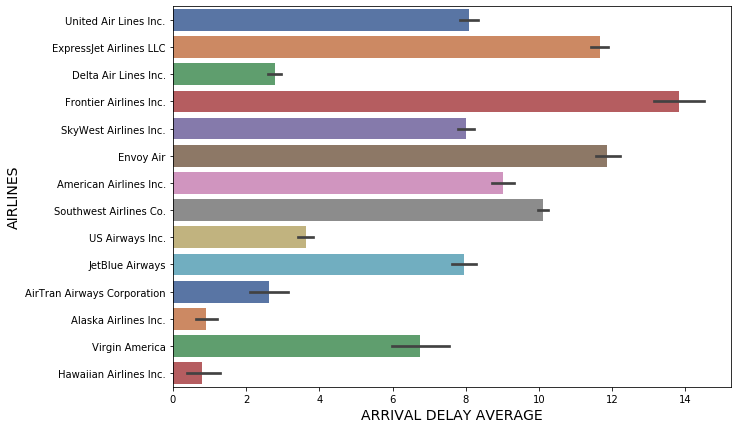

In [36]:
# Promedio del retraso por aerolínea
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY",data=list_data[0],palette='deep')
plt.xlabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.show()

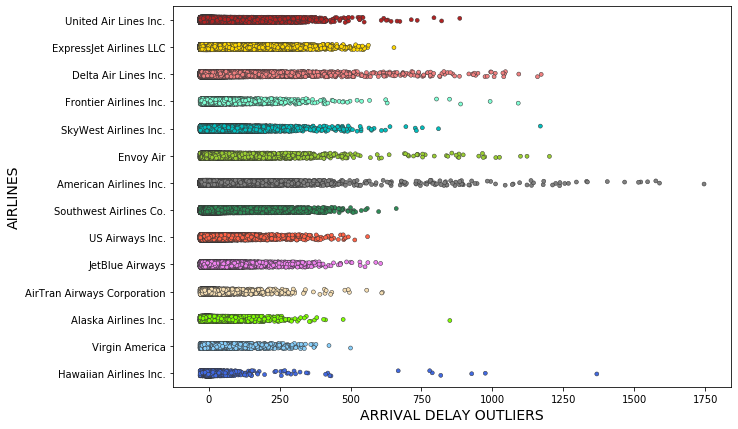

<Figure size 720x504 with 0 Axes>

In [12]:
# Distribución del retraso por aerolínea
%matplotlib inline
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=list_data[0], linewidth = 0.5,  jitter=True)
plt.xlabel('ARRIVAL DELAY OUTLIERS', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

In [13]:
# Estadística global por aerolínea
global_stats = list_data[0]['ARRIVAL_DELAY'].groupby(list_data[0]['AIRLINE_NAME']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE_NAME,,,,
Virgin America,-30.0,500.0,11176.0,6.739621
Hawaiian Airlines Inc.,-30.0,1368.0,14580.0,0.810151
AirTran Airways Corporation,-30.0,612.0,15345.0,2.620072
Frontier Airlines Inc.,-30.0,1091.0,16966.0,13.834964
Alaska Airlines Inc.,-30.0,850.0,30728.0,0.915191
JetBlue Airways,-30.0,606.0,47829.0,7.942754
Envoy Air,-30.0,1201.0,73508.0,11.869919
US Airways Inc.,-30.0,560.0,80229.0,3.630483
United Air Lines Inc.,-30.0,885.0,94074.0,8.085443


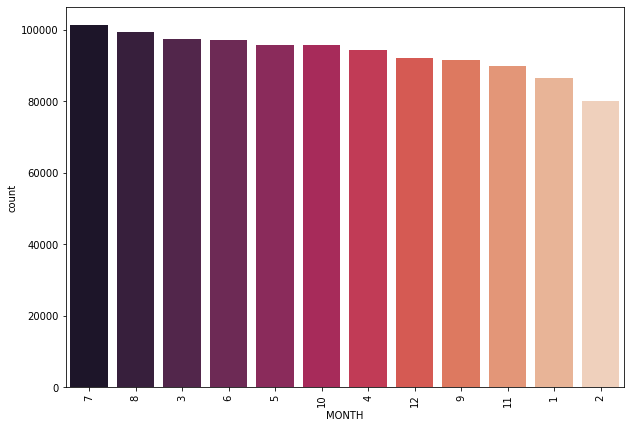

In [35]:
## Análisis Temporal
df_date= list_data[0]

df_date['DATE_TIME']=pd.to_datetime(df_date['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_date['MONTH']=[ x.month for x in df_date['DATE_TIME']]
df_date['DAYOFWEEK']=[ x.dayofweek for x in df_date['DATE_TIME']]
# Total de vuelos por mes del año
plt.figure(figsize=(10,7))
g=sns.countplot(x='MONTH', data=df_date, palette="rocket", order = df_date['MONTH'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

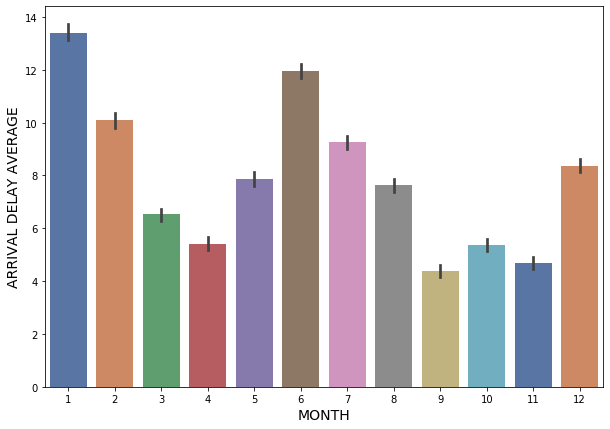

In [33]:
# Promedio de retraso por mes
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="ARRIVAL_DELAY", x="MONTH",data=df_date,palette='deep')
plt.xlabel('MONTH', fontsize=14)
plt.ylabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.show()

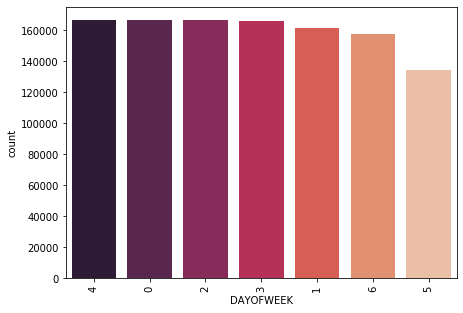

In [34]:
# Total de vuelos por día de la semana
plt.figure(figsize=(7,5))
g=sns.countplot(x='DAYOFWEEK', data=df_date, palette="rocket", order = df_date['DAYOFWEEK'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

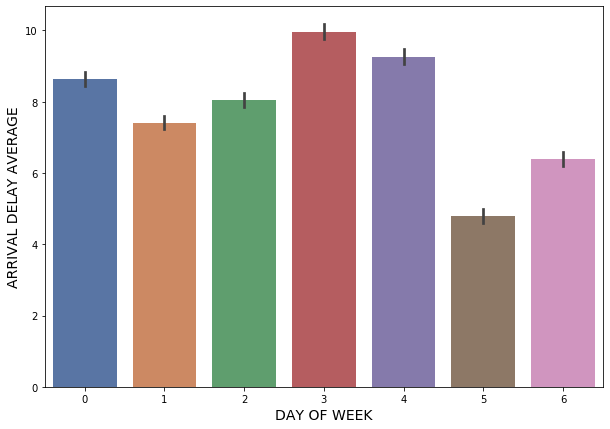

In [38]:
# Promedio de retraso por día de la semana
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="ARRIVAL_DELAY", x="DAYOFWEEK",data=df_date,palette='deep')
plt.xlabel('DAY OF WEEK', fontsize=14)
plt.ylabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.show()

(12.0, 0.0)

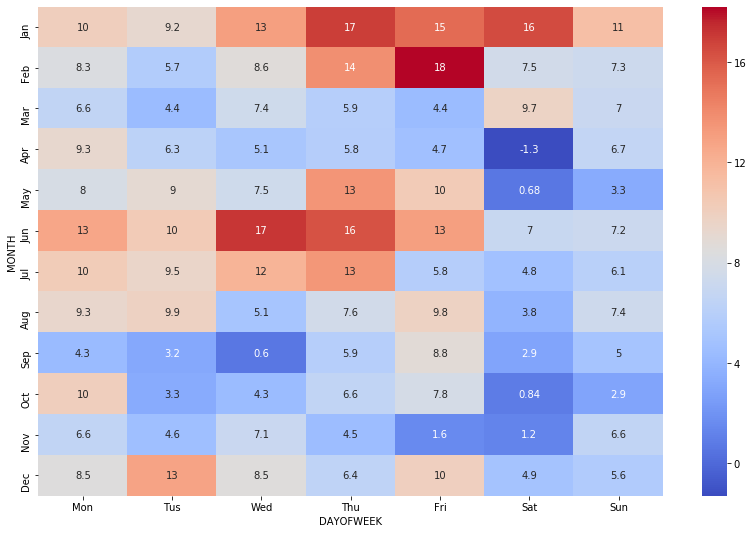

In [43]:
# Matriz de correlación Mes-Día de la semana
pt=df_date.pivot_table(index="MONTH",columns="DAYOFWEEK",values="ARRIVAL_DELAY", aggfunc=np.mean)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
days=['Mon','Tus','Wed','Thu','Fri','Sat','Sun']
plt.figure(figsize = (14,9))

ax = sns.heatmap(pt, annot=True,xticklabels=days,yticklabels=months, cmap="coolwarm")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [98]:
## Análisis por aeropuertos
airport_stats=data['ARRIVAL_DELAY'].groupby(data['ORIGIN']).apply(get_stats).unstack()
air=airport_stats.sort_values('count')
air

,min,max,count,mean,IATA_CODE,OR_LATITUDE,OR_LONGITUDE
0,-9.0,38.0,9.0,9.777778,DLG,59.04541,-158.50334
1,-28.0,352.0,12.0,32.583333,ESC,45.72267,-87.09373
2,-24.0,32.0,13.0,-10.692308,HYA,41.66934,-70.28036
3,-13.0,67.0,15.0,17.866667,GST,58.42438,-135.70738
4,-18.0,52.0,15.0,9.533333,AKN,58.67680,-156.64922
...,...,...,...,...,...,...,...
312,-30.0,818.0,42941.0,6.726019,LAX,33.94254,-118.40807
313,-30.0,1187.0,43896.0,11.717013,DEN,39.85841,-104.66700
314,-30.0,1151.0,54058.0,15.111954,ORD,41.97960,-87.90446
315,-30.0,877.0,54124.0,11.167578,DFW,32.89595,-97.03720


In [99]:
airport_stats=data['ARRIVAL_DELAY'].groupby(data['ORIGIN']).apply(get_stats).unstack()
air=airport_stats.sort_values('mean')
air=geo(air)
air

,min,max,count,mean,IATA_CODE,OR_LATITUDE,OR_LONGITUDE
0,-30.0,13.0,103.0,-14.427184,CNY,38.75496,-109.75484
1,-24.0,32.0,13.0,-10.692308,HYA,41.66934,-70.28036
2,-30.0,133.0,163.0,-8.662577,BTM,45.95480,-112.49746
3,-30.0,122.0,196.0,-8.030612,PIH,42.91131,-112.59586
4,-30.0,80.0,135.0,-7.044444,ABR,45.44906,-98.42183
...,...,...,...,...,...,...,...
312,-27.0,478.0,131.0,26.335878,ILG,39.67872,-75.60653
313,-29.0,370.0,158.0,30.544304,CEC,41.78016,-124.23653
314,-28.0,203.0,81.0,31.913580,OTH,43.41714,-124.24603
315,-28.0,352.0,12.0,32.583333,ESC,45.72267,-87.09373


In [40]:
### SELECCIÓN DEL MODELO

## Preparación de las variables
# Filtramos American Airlines (AA)
df_AA=list_data[0][list_data[0]['AIRLINE']=='AA']
variables_to_remove=['AIRLINE','AIRLINE_NAME','OR_LATITUDE', 'OR_LONGITUDE', 'DEST_LATITUDE', 
                 'DEST_LONGITUDE','DEPARTURE_DELAY','DISTANCE']
df_AA=df_AA.drop(variables_to_remove, axis=1)

# Creamos las variables de tiempo para el modelo
df_AA['DATE_TIME']=pd.to_datetime(df_AA['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_AA['MONTH']=[ x.month for x in df_AA['DATE_TIME']]
df_AA['HOUR']=[ x.hour for x in df_AA['DATE_TIME']]
df_AA['DAYOFWEEK']=[ x.dayofweek for x in df_AA['DATE_TIME']]

#Transformamos la hora de salida a segundos
df_AA['SCHEDULED_DEPARTURE']=pd.to_datetime(df_AA['SCHED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_AA['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_AA['SCHED_DEPARTURE']]) #conversion to seconds

#Variables categóricas para Origen y Destino
le=LabelEncoder()
df_AA['ORIGIN_LABEL']=le.fit_transform(df_AA['ORIGIN'])
df_AA['DESTIN_LABEL']=le.fit_transform(df_AA['DESTIN'])

#Creamos la columna de clases
df_AA['DELAY LEVEL']=df_AA.apply(classes, axis=1)

#Visualizamos las transformaciones
df_AA_DATE=df_AA.groupby(df_AA['DATE_TIME'])

df_AA_DATE.head()


,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DATE_TIME,MONTH,HOUR,DAYOFWEEK,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL,DELAY LEVEL
8108,2014-11-05,DFW,IAH,10:30:00,11:35:00,-1.0,2014-11-05 10:30:00,11,10,2,37800,17,31,0
8109,2014-01-27,DFW,IAH,17:50:00,19:00:00,-14.0,2014-01-27 17:50:00,1,17,0,64200,17,31,0
8111,2014-07-18,DFW,IAH,12:45:00,13:50:00,2.0,2014-07-18 12:45:00,7,12,4,45900,17,31,0
8112,2014-02-22,DFW,IAH,21:15:00,22:20:00,-7.0,2014-02-22 21:15:00,2,21,5,76500,17,31,0
8116,2014-08-21,DFW,IAH,18:10:00,19:10:00,1.0,2014-08-21 18:10:00,8,18,3,65400,17,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114716,2014-01-15,MIA,STX,11:00:00,14:35:00,12.0,2014-01-15 11:00:00,1,11,2,39600,48,82,0
1114717,2014-01-11,MIA,STX,16:55:00,20:30:00,2.0,2014-01-11 16:55:00,1,16,5,60900,48,82,0
1114718,2014-03-29,MIA,STX,18:05:00,20:40:00,25.0,2014-03-29 18:05:00,3,18,5,65100,48,82,1
1114719,2014-08-17,MIA,STX,10:40:00,13:25:00,-8.0,2014-08-17 10:40:00,8,10,6,38400,48,82,0


In [11]:
#Comprobamos que se le asigna la misma etiqueta a origen y destino iguales
le.fit(df_AA['ORIGIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)


{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'MTJ': 52, 'OGG': 53, 'OKC': 54, 'OMA': 55, 'ONT': 56, 'ORD': 57, 'ORF': 58, 'PBI': 59, 'PDX': 60, 'PHL': 61, 'PHX': 62, 'PIT': 63, 'PNS': 64, 'PSP': 65, 'RDU': 66, 'RIC': 67, 'RNO': 68, 'RSW': 69, 'SAN': 70, 'SAT': 71, 'SDF': 72, 'SEA': 73, 'SFO': 74, 'SJC': 75, 'SJU': 76, 'SLC': 77, 'SMF': 78, 'SNA': 79, 'STL': 80, 'STT': 81, 'STX': 82, 'TPA': 83, 'TUL': 84, 'TUS': 85, 'XNA': 86}


In [12]:
le.fit(df_AA['DESTIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'MTJ': 52, 'OGG': 53, 'OKC': 54, 'OMA': 55, 'ONT': 56, 'ORD': 57, 'ORF': 58, 'PBI': 59, 'PDX': 60, 'PHL': 61, 'PHX': 62, 'PIT': 63, 'PNS': 64, 'PSP': 65, 'RDU': 66, 'RIC': 67, 'RNO': 68, 'RSW': 69, 'SAN': 70, 'SAT': 71, 'SDF': 72, 'SEA': 73, 'SFO': 74, 'SJC': 75, 'SJU': 76, 'SLC': 77, 'SMF': 78, 'SNA': 79, 'STL': 80, 'STT': 81, 'STX': 82, 'TPA': 83, 'TUL': 84, 'TUS': 85, 'XNA': 86}


In [38]:
#CORRELATION MATRIX (Pearson Correlation)
corr = df_AA.corr()
corr.style.background_gradient(cmap='coolwarm')

,ARRIVAL_DELAY,MONTH,HOUR,DAYOFWEEK,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL,DELAY LEVEL
ARRIVAL_DELAY,1,0.024162,0.0992507,-0.0235048,0.0990865,-0.0261102,0.013566,0.698159
MONTH,0.024162,1,-0.00531847,-0.0127952,-0.00525074,-0.00849085,-0.00196326,0.0243101
HOUR,0.0992507,-0.00531847,1,-0.00127473,0.997961,-0.0802657,0.0793419,0.149952
DAYOFWEEK,-0.0235048,-0.0127952,-0.00127473,1,-0.00107319,0.00672688,0.00246316,-0.0261421
SCHEDULED_DEPARTURE,0.0990865,-0.00525074,0.997961,-0.00107319,1,-0.0819585,0.0802812,0.14987
ORIGIN_LABEL,-0.0261102,-0.00849085,-0.0802657,0.00672688,-0.0819585,1,-0.0750856,-0.0276204
DESTIN_LABEL,0.013566,-0.00196326,0.0793419,0.00246316,0.0802812,-0.0750856,1,0.0279051
DELAY LEVEL,0.698159,0.0243101,0.149952,-0.0261421,0.14987,-0.0276204,0.0279051,1


In [41]:
#MODELO DE CLASIFICACIÓN
#Eliminamos las variables que no se usan en el entrenamiento
df_AA.drop(['DATE','ORIGIN','DESTIN','SCHED_DEPARTURE',
                        'SCHED_ARRIVAL','DATE_TIME','ARRIVAL_DELAY'], inplace=True, axis=1)
#Separamos la columna con la información del delay_level
X = np.array(df_AA.drop(['DELAY LEVEL'],1))
y = np.array(df_AA['DELAY LEVEL'])

In [28]:
#Separamos los datos en train y test, con una proporción de un 70% y 30%, respectivamente.
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)
#Escalamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
df_AA.head()

,MONTH,DAYOFWEEK,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL,DELAY LEVEL
8108,11,2,37800,17,31,0
8109,1,0,64200,17,31,0
8111,7,4,45900,17,31,0
8112,2,5,76500,17,31,0
8116,8,3,65400,17,31,0


In [30]:
#Comprobamos el balance de las clases y lo ajustamos
df_AA['DELAY LEVEL'].value_counts()

0    80181
1    14946
2     8978
Name: DELAY LEVEL, dtype: int64

In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weights)

[0.43290205 2.327839   3.83986721]


In [89]:
class_weight = dict({0:0.43, 1:2.3, 2:3.8})

In [49]:
## Decision Tree Classifier
tree = DecisionTreeClassifier(random_state = 42, class_weight='balanced')
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [50]:
#Precisión en la clasificación de los valores de entrenamiento
acc_tree_train = round(tree.score(X_train, y_train) * 100, 2)
print ('1. Train accuracy {}\n'.format(acc_tree_train))

# Precisión en la clasificación de los valores de test
acc_tree = accuracy_score(y_test, y_pred_tree)
print ('2. Test accuracy {}\n'.format(acc_tree*100))

# Report
print('3. Classfication Report \n{}\n'.format(classification_report(y_test,y_pred_tree)))

# Matriz de confusión
print('4. Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tree))

1. Train accuracy 100.0

2. Test accuracy 65.78871294125204

3. Classfication Report 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     23920
           1       0.19      0.19      0.19      4495
           2       0.22      0.22      0.22      2718

    accuracy                           0.66     31133
   macro avg       0.40      0.40      0.40     31133
weighted avg       0.66      0.66      0.66     31133


4. Confusion Matrix
[[19023  3271  1626]
 [ 3119   865   511]
 [ 1622   502   594]]


In [51]:
## Ridge Classifier
rid = RidgeClassifier(random_state = 42, class_weight='balanced')
rid.fit(X_train, y_train)
y_pred_rid = rid.predict(X_test)

In [52]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rid_train = round(rid.score(X_train, y_train) * 100, 2)
print ('1. Train accuracy {}\n'.format(acc_rid_train))

# Precisión en la clasificación de los valores de test
acc_rid = accuracy_score(y_test, y_pred_rid)
print ('2. Test accuracy {}\n'.format(acc_rid*100))

# Report
print('3. Classfication Report \n{}\n'.format(classification_report(y_test,y_pred_rid)))

# Matriz de confusión
print('4. Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rid))

1. Train accuracy 50.35

2. Test accuracy 50.1943275623936

3. Classfication Report 
              precision    recall  f1-score   support

           0       0.82      0.58      0.68     23920
           1       0.17      0.09      0.12      4495
           2       0.12      0.52      0.19      2718

    accuracy                           0.50     31133
   macro avg       0.37      0.40      0.33     31133
weighted avg       0.66      0.50      0.55     31133


4. Confusion Matrix
[[13798  1748  8374]
 [ 2003   411  2081]
 [ 1051   249  1418]]


In [53]:
#Gaussian Naive Bayes
naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred_naive = naive.predict(X_test)

In [54]:
#Precisión en la clasificación de los valores de entrenamiento
acc_naive_train = round(naive.score(X_train, y_train) * 100, 2)
print ('1. Train accuracy {}\n'.format(acc_naive_train))

# Precisión en la clasificación de los valores de test
acc_naive = accuracy_score(y_test, y_pred_naive)
print ('2. Test accuracy {}\n'.format(acc_naive*100))

# Report
print('3. Classfication Report \n{}\n'.format(classification_report(y_test,y_pred_naive)))

# Matriz de confusión
print('4. Confusion Matrix')
print(confusion_matrix(y_test, y_pred_naive))

1. Train accuracy 76.76

2. Test accuracy 76.83165772652812

3. Classfication Report 
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     23920
           1       0.00      0.00      0.00      4495
           2       0.00      0.00      0.00      2718

    accuracy                           0.77     31133
   macro avg       0.26      0.33      0.29     31133
weighted avg       0.59      0.77      0.67     31133


4. Confusion Matrix
[[23920     0     0]
 [ 4495     0     0]
 [ 2718     0     0]]


C:\Users\alex_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
#Radom Forest Classifier
rnd_forest = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', random_state = 42, class_weight='balanced')
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

In [35]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rnd_forest_train = round(rnd_forest.score(X_train, y_train) * 100, 2)
print ('1. Train accuracy {}\n'.format(acc_rnd_forest_train))

# Precisión en la clasificación de los valores de test
acc_rnd_forest = accuracy_score(y_test, y_pred_rnd_forest)
print ('2. Test accuracy {}\n'.format(acc_rnd_forest*100))

# Report
print('3. Classfication Report \n{}\n'.format(classification_report(y_test,y_pred_rnd_forest)))

# Matriz de confusión
print('4. Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rnd_forest))

1. Train accuracy 93.7

2. Test accuracy 71.09695184426229

3. Classfication Report 
              precision    recall  f1-score   support

           0       0.78      0.90      0.83     24069
           1       0.20      0.10      0.13      4511
           2       0.15      0.08      0.10      2652

    accuracy                           0.71     31232
   macro avg       0.38      0.36      0.36     31232
weighted avg       0.64      0.71      0.67     31232


4. Confusion Matrix
[[21549  1594   926]
 [ 3806   447   258]
 [ 2193   250   209]]


In [39]:
#El ranking final quedaría:
results = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Ridge','Random Forest','Gaussian Naive Bayes'],
    'Precisión': [acc_tree*100, acc_rid*100, acc_rnd_forest*100, acc_naive*100]})
result_df = results.sort_values(by='Precisión', ascending=False)
result_df = result_df.set_index('Precisión')
result_df.head()

,Modelo
Precisión,
76.831658,Gaussian Naive Bayes
76.616452,Random Forest
65.788713,Decision Tree
50.194328,Ridge


C:\Users\alex_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.2046139  0.15774247 0.05291773 0.22908115 0.17565841 0.17998636]


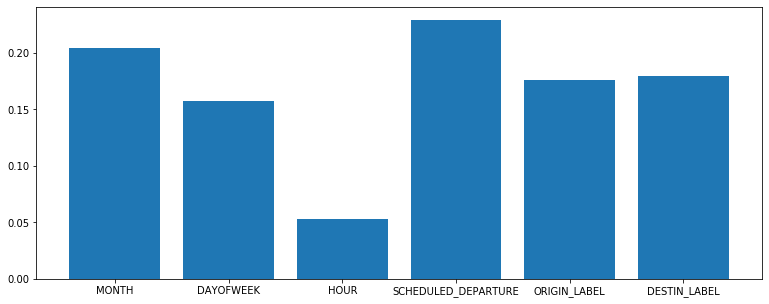

In [98]:
#IMPORTANCIA DE VARIABLES
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()
features=df_AA.drop('DELAY LEVEL',axis=1)
#Ajustamos el modelo
model.fit(X_train,y_train)

#Pedimos que nos muestre la importancia de cada variable
print(model.feature_importances_)

#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
plt.figure(figsize=(13,5))
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), features)
pyplot.show()